In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## 1) Loading Data:

In [25]:
df = pd.read_csv(r"..\Dados\Tabela_final\tabela_final_edu.csv")

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 63 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IBGE7                1170 non-null   int64  
 1   UF                   1170 non-null   object 
 2   NOME                 1170 non-null   object 
 3   LATITUDE             1170 non-null   float64
 4   LONGITUDE            1170 non-null   float64
 5   DIST_EF_PUB          1170 non-null   float64
 6   DIST_EM_PUB          1170 non-null   float64
 7   IDEB_AI              1170 non-null   float64
 8   IDEB_AF              1170 non-null   float64
 9   DOCSUP_EF_PUB        1170 non-null   float64
 10  DOCSUP_EM_PUB        1170 non-null   float64
 11  TXNASC7C             1170 non-null   float64
 12  TXNBAIXOP            1170 non-null   float64
 13  PINTERSAP            1170 non-null   float64
 14  PINTERDRSAI          1170 non-null   float64
 15  REN_PIBPC_D          1170 non-null   f

In [27]:
lista_colunas = [coluna for coluna in df.columns if (df[coluna].dtype == 'float64')&(coluna not in ['LATITUDE', 'LONGITUDE'])]

In [28]:
df_final_merged = df[lista_colunas]

In [29]:
df_final_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 58 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DIST_EF_PUB          1170 non-null   float64
 1   DIST_EM_PUB          1170 non-null   float64
 2   IDEB_AI              1170 non-null   float64
 3   IDEB_AF              1170 non-null   float64
 4   DOCSUP_EF_PUB        1170 non-null   float64
 5   DOCSUP_EM_PUB        1170 non-null   float64
 6   TXNASC7C             1170 non-null   float64
 7   TXNBAIXOP            1170 non-null   float64
 8   PINTERSAP            1170 non-null   float64
 9   PINTERDRSAI          1170 non-null   float64
 10  REN_PIBPC_D          1170 non-null   float64
 11  PDEFAGUA             1170 non-null   float64
 12  PDEFESGOTO           1170 non-null   float64
 13  PANALF15             1170 non-null   float64
 14  PIND_POS             1170 non-null   float64
 15  SNIS_PAGUA           1170 non-null   f

## 2) Preprocessamento

### 2.1) Scalling

#### 2.1.1) StandardScaler

In [10]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_final_merged)

In [11]:
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_final_merged.columns

### 2.2) Dimensionality Reduction

#### 2.2.1) PCA

In [12]:
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)

Número de componentes para 0.95 de variância: 37


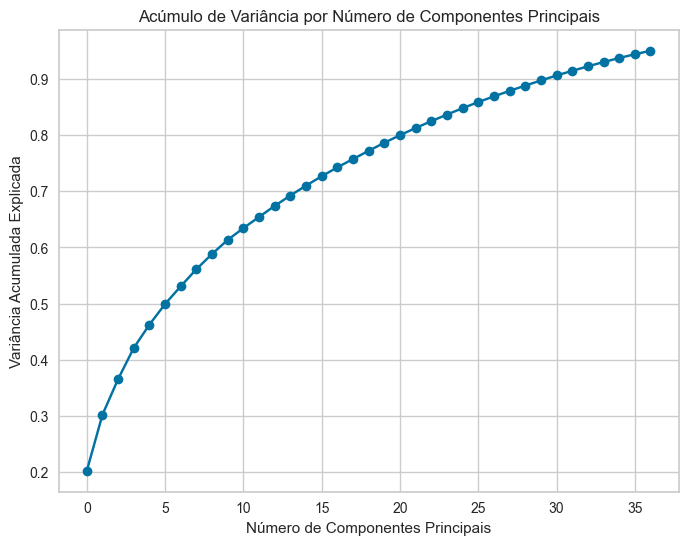

In [17]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Crie um gráfico para visualizar o acúmulo de variância
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o', linestyle='-')
print("Número de componentes para 0.95 de variância:", df_pca.shape[1])
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Acumulada Explicada')
plt.title('Acúmulo de Variância por Número de Componentes Principais')
plt.grid(True)
plt.show()


#### 2.2.2) T-SNE

In [19]:
def plot_clusters(df, df_components, clusters):
    df[['COMPONENT1', 'COMPONENT2']] = df_components
    df['CLUSTER'] = clusters

    actual_cities = df[['NOME', 'COMPONENT1', 'COMPONENT2', 'CLUSTER']].loc[df['NOME'].isin(['MAURITI', 'SÃO JOSÉ DA TAPERA', 'BUÍQUE', 'INAJÁ'])]

    print(actual_cities)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='COMPONENT1', y='COMPONENT2', hue='CLUSTER', palette='Set2')
    sns.scatterplot(data=actual_cities, x='COMPONENT1', y='COMPONENT2', marker = 'X', color='black', s=100, label='Cidades atuais')
    for i, row in actual_cities.iterrows():
        plt.text(row['COMPONENT1'] + 0.1, row['COMPONENT2'], row['NOME'], fontsize=12)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.title('Visualização dos Clusters')
    plt.legend(title='Cluster', loc='upper right')
    plt.grid(True)
    plt.show()

In [20]:
tsne = TSNE(n_components=2, random_state=42)
df_components = tsne.fit_transform(df_pca)

## Clustering

### 2.3) Kmeans:

#### 2.3.1) Elbow curve

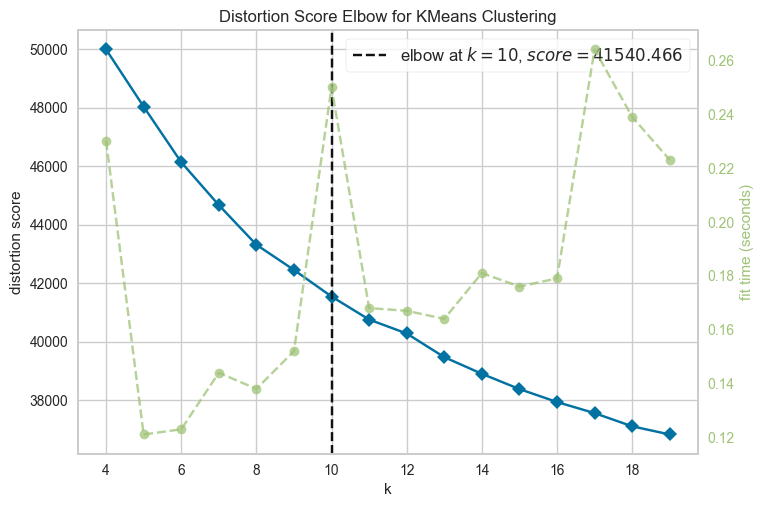

In [21]:
model = KMeans(n_init=20, random_state=42)
visualizer = KElbowVisualizer(model, k=(4,20))
visualizer.fit(df_pca)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

#### 2.3.2) Silhouette_score

In [30]:
def best_silhuet_score(data):
    best_silhuet = 0
    best_k = 0
    for i in range(2, 21):
        kmean = KMeans(n_clusters=i, n_init=20, random_state=42)
        centroids = kmean.fit_transform(df_pca)
        score = silhouette_score(df_pca, kmean.labels_)
        if score > best_silhuet:
            best_silhuet = score
            best_k = i
        
    return best_k, best_silhuet

In [31]:
best_k, best_silhuet = best_silhuet_score(df_pca)

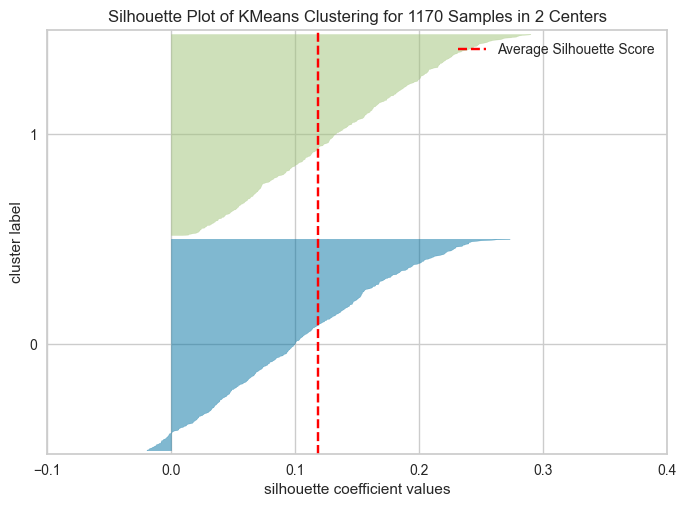

Silhouette avg: 0.11832515653014435


In [32]:
kmean = KMeans(n_clusters=best_k, n_init=20, random_state=42)
visualizer = SilhouetteVisualizer(kmean, colors="yellowbrick")
visualizer.fit(df_pca)
visualizer.show();
print("Silhouette avg:", visualizer.silhouette_score_)

#### 2.3.3) Métricas finais:

Silhouette Score:  0.1183
Davies-Bouldin Score:  2.4594
Calinski-Harabasz Index:  177.0288
                   NOME  COMPONENT1  COMPONENT2  CLUSTER
34   SÃO JOSÉ DA TAPERA  -29.419579    9.421972        0
418             MAURITI   15.007096   23.928398        1
705              BUÍQUE  -30.521114    6.705474        0
736               INAJÁ  -32.231869    5.977004        0


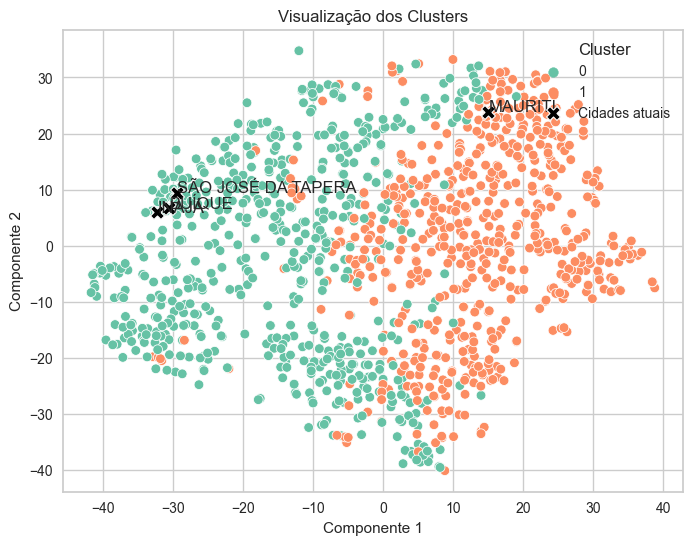

In [33]:
kmeans = KMeans(best_k, random_state = 42, n_init=20)
clusters = kmeans.fit_predict(df_pca)
print('Silhouette Score: ',round(silhouette_score(df_pca, clusters), 4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_pca, clusters), 4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_pca, clusters), 4))
plot_clusters(df, df_components, clusters)

### 2.4) Hirarchical clustering:

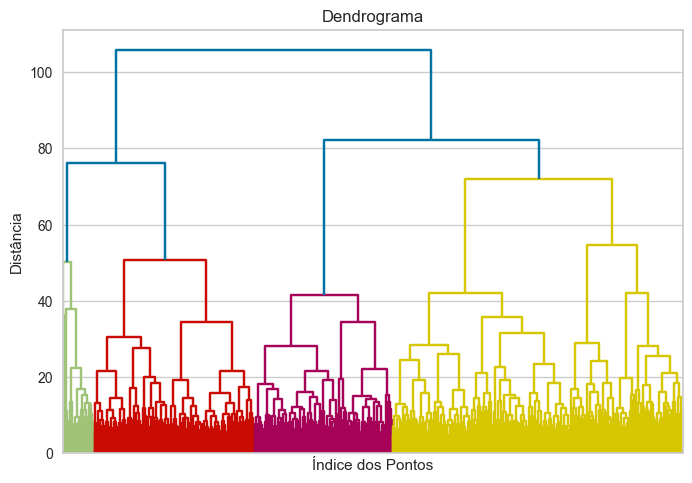

In [34]:
linkage_matrix = linkage(df_pca, method='ward')

plt.figure()
dendrogram(linkage_matrix)
plt.title('Dendrograma')
plt.xticks([])
plt.xlabel('Índice dos Pontos')
plt.ylabel('Distância')
plt.show()

Silhouette Score:  0.0664
Davies-Bouldin Score:  2.6893
Calinski-Harabasz Index:  84.2695
                   NOME  COMPONENT1  COMPONENT2  CLUSTER
34   SÃO JOSÉ DA TAPERA  -29.419579    9.421972        0
418             MAURITI   15.007096   23.928398        1
705              BUÍQUE  -30.521114    6.705474        0
736               INAJÁ  -32.231869    5.977004        0


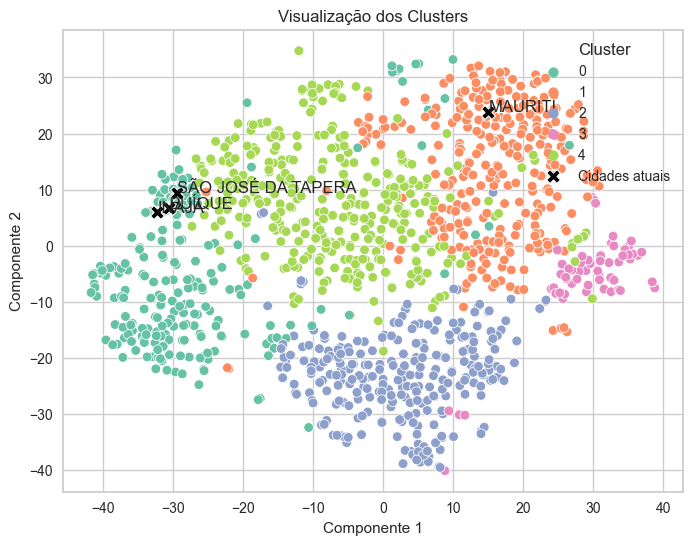

In [35]:
hclustering = AgglomerativeClustering(n_clusters=5)
clusters = hclustering.fit_predict(df_pca)
print('Silhouette Score: ',round(silhouette_score(df_pca, clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_pca, clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_pca, clusters),4))
plot_clusters(df, df_components, clusters)